# Introduction
In this competition, we have to develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

**About the Host**
![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1095143%2Ff9ab8963dea5e7c1716f47310daa96ab%2FASHRAE_Logo_25.jpg?generation=1570808142334850&alt=media)

Founded in 1894, ASHRAE serves to advance the arts and sciences of heating, ventilation, air conditioning refrigeration and their allied fields. ASHRAE members represent building system design and industrial process professionals around the world. With over 54,000 members serving in 132 countries, ASHRAE supports research, standards writing, publishing and continuing education - shaping tomorrow’s built environment today.

# 1. Importing Packages and Collecting Data

In [1]:
'''Importing Data Manipulattion Moduls'''
import numpy as np
import pandas as pd
from scipy import stats
import os, gc

In [2]:
'''Seaborn and Matplotlib Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")                    
%matplotlib inline

In [3]:
'''plotly Visualization'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True)

In [4]:
'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [5]:
'''Read the dataset from csv file'''

'Read the dataset from csv file'

In [6]:
building = pd.read_csv('../raw_data/building_metadata.csv')

In [7]:
weather_train = pd.read_csv('../raw_data/weather_train.csv')

In [8]:
weather_test = pd.read_csv('../raw_data/weather_test.csv')

In [9]:
train = pd.read_csv('../raw_data/train.csv') 

In [10]:
test = pd.read_csv('../raw_data/test.csv')

In [11]:
'''Read the dataset from csv file
building = pd.read_csv('../raw_data/building_metadata.csv')
weather_train = pd.read_csv('../raw_data/weather_train.csv')
weather_test = pd.read_csv('../raw_data/weather_test.csv')
train = pd.read_csv('../raw_data/train.csv') 
test = pd.read_csv('../raw_data/test.csv')'''

"Read the dataset from csv file\nbuilding = pd.read_csv('../raw_data/building_metadata.csv')\nweather_train = pd.read_csv('../raw_data/weather_train.csv')\nweather_test = pd.read_csv('../raw_data/weather_test.csv')\ntrain = pd.read_csv('../raw_data/train.csv') \ntest = pd.read_csv('../raw_data/test.csv')"

# 2. Variable Description and Identification

In [11]:
'''Train and test data at a glance.'''
bold('**Preview of building data**')
display(building.head(3))
bold('**Preview of Weather Train Data:**')
display(weather_train.head(3))
bold('**Preview of Weather Test Data:**')
display(weather_test.head(3))
bold('**Preview of Train Data:**')
display(train.head(3))
bold('**Preview of Test Data:**')
display(test.head(3))

**Preview of building data**

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


**Preview of Weather Train Data:**

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


**Preview of Weather Test Data:**

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1


**Preview of Train Data:**

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0


**Preview of Test Data:**

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00


In [12]:
'''Dimension of train and test data'''
bold('**Shape of our train and test data**')
print('Dimension of building:', building.shape) 
print('Dimension of Weather train:',weather_train.shape) 
print('Dimension of Weather test:', weather_test.shape)
print('Dimension of train:',train.shape) 
print('Dimension of test:',test.shape)

**Shape of our train and test data**

Dimension of building: (1449, 6)
Dimension of Weather train: (139773, 9)
Dimension of Weather test: (277243, 9)
Dimension of train: (20216100, 4)
Dimension of test: (41697600, 4)


In [13]:
'''Merging datasets'''
train = train.merge(building, on = 'building_id', how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')

train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del weather_train, weather_test,building

In [14]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.as_ordered()
            

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.6+ GB


In [16]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 790.78 MB
Decreased by 69.8%
Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.04 MB
Decreased by 69.8%


### Variable Desicription
**Train**
* *building_id* - Foreign key for the building metadata.
* *meter* - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* *timestamp* - When the measurement was taken
* *meter_reading* - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

**building_meta**
* *site_id* - Foreign key for the weather files.
* *building_id* - Foreign key for training.csv
* *primary_use* - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* *square_feet* - Gross floor area of the building
* *year_built* - Year building was opened
* *floor_count* - Number of floors of the building

**weather_[train/test]**
* Weather data from a meteorological station as close as possible to the site.
* *air_temperature* - Degrees Celsius
* *cloud_coverage* - Portion of the sky covered in clouds, in oktas
* *dew_temperature* - Degrees Celsius
* *precip_depth_1_hr* - Millimeters
* *sea_level_pressure* - Millibar/hectopascals
* *wind_direction* - Compass direction (0-360)
* *wind_speed* - Meters per second

In [17]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [19]:
bold('**Variable Description of  train Data:**')
description(train)

**Variable Description of  train Data:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0.0,0.0,0.0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,12127645,116,2008.0,2004.0,1991.0
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25.0,25.0,25.0


In [18]:
bold('**Variable Description of  train Data:**')
description(test)

**Variable Description of  train Data:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,row_id,int32,0,41697600,0,1,2
1,building_id,int16,0,1449,0,1,2
2,meter,int8,0,4,0,0,0
3,timestamp,category,0,17520,2017-01-01 00:00:00,2017-01-01 00:00:00,2017-01-01 00:00:00
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,24598080,116,2008.0,2004.0,1991.0
8,floor_count,float16,34444320,18,NaN,NaN,NaN
9,air_temperature,float16,221901,639,17.796875,17.796875,17.796875


**Well! we have lot of missing value in the both train and test data.**

# Feature Engineering - Part I
The code block below will be expanded on over time as I come up with some new features.

Engineered features include:

* Month of the year
* Day of the week of the timestamp
* Hour of the day

In [19]:
train["timestamp"] = pd.to_datetime(train["timestamp"])

In [20]:
train.timestamp.dt.name

'timestamp'

In [21]:
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)
#train["weekday_name"] = train["timestamp"].dt.weekday_name 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)

test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = np.uint8(test["timestamp"].dt.hour)
test["day"] = np.uint8(test["timestamp"].dt.day)
test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
test["month"] = np.uint8(test["timestamp"].dt.month)

In [24]:
#train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
#test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

# 3. Exploratory Data Analysis (EDA)

## 3.1 Target Variable Analysis:- meter_reading

In [22]:
'''Function to distribution plot'''
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (18, 10)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()

/Users/anaflaviagama/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



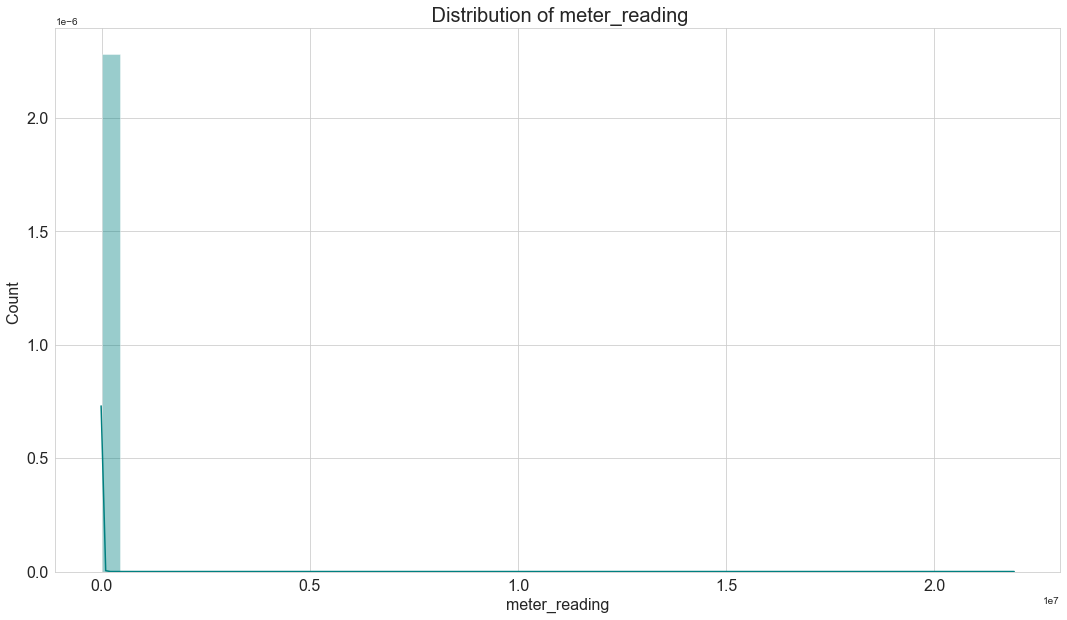

In [26]:
'''Distribution of the Meter Reading'''
distplot(train['meter_reading'], 'teal')

**It's seems that meter reading variable is heavily positive skewed with outliears.
Let's fixed that.**


In [23]:
'''Summary of meter reading'''
train['meter_reading'].describe()

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

**Distribution after log tranformation**

/Users/anaflaviagama/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



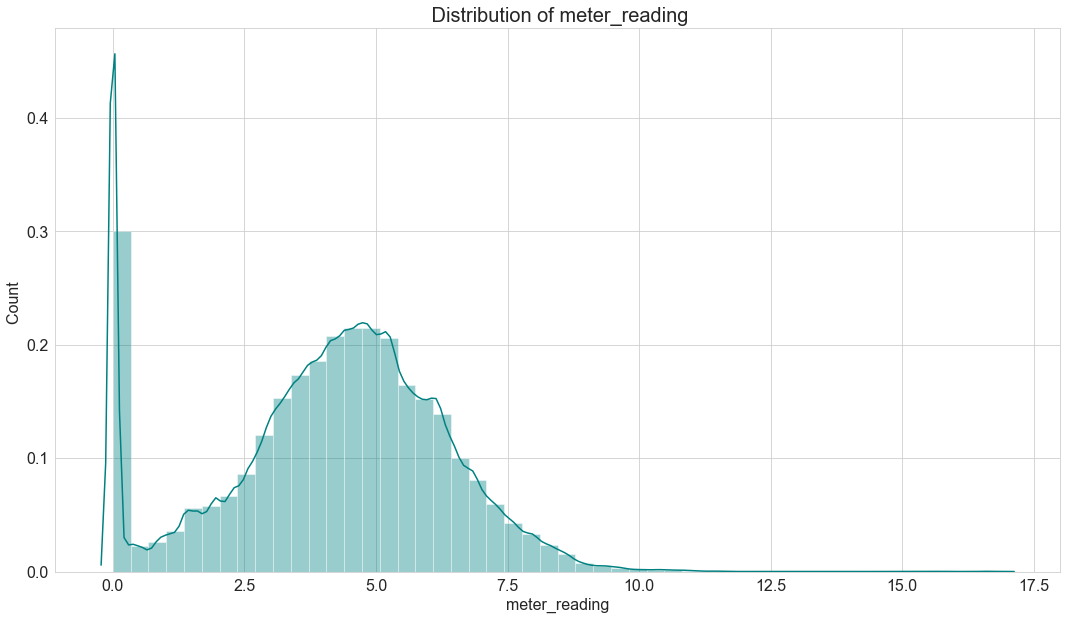

In [24]:
'''Log tranformation of meter_reading'''
train['meter_reading'] = np.log1p(train['meter_reading'])

bold('**Distribution after log tranformation**')
distplot(train['meter_reading'], 'teal')

## 3.2 Meter Reading and Meter Type
There are four different meter types and are displayed below:

* 0: electricity
* 1: chilledwater
* 2: steam
* 3: hotwater

We can see that the steam meter type tends to have higher meter readings, while electricity tends to have the lowest energy readings.

**ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED**

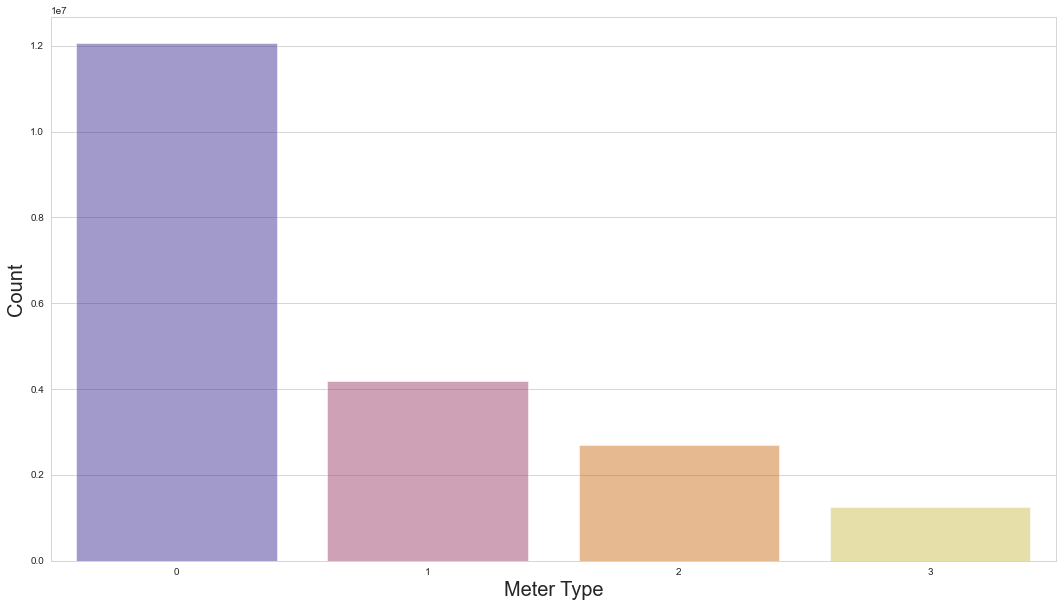

In [25]:
bold('**ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data = train, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Meter Type', fontsize = 20)
plt.show()

**THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT**

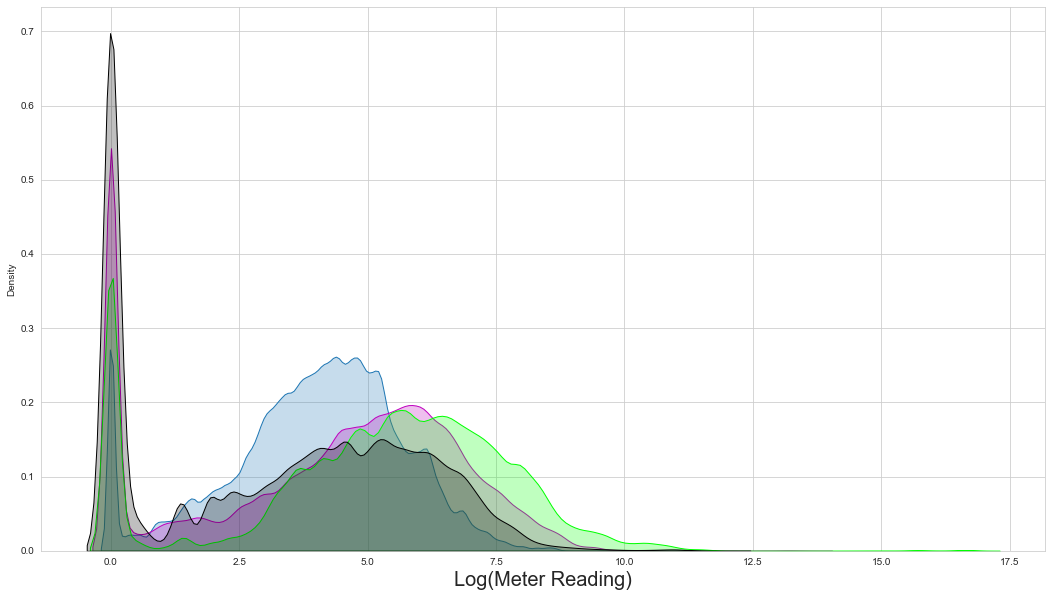

In [26]:
bold('**THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT**')
plt.rcParams['figure.figsize'] = (18, 10)

temp_df = train[train["meter"]==0]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="electricity")
temp_df = train[train["meter"]==1]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="chill water", color = 'm')
temp_df = train[train["meter"]==2]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="steam", color = 'lime')
temp_df = train[train["meter"]==3]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="hot water", color = 'k')
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
plt.show()

## 3.3 Weekday and Meter Reading

**SUNDAYS HAVE THE LOWEST READINGS**

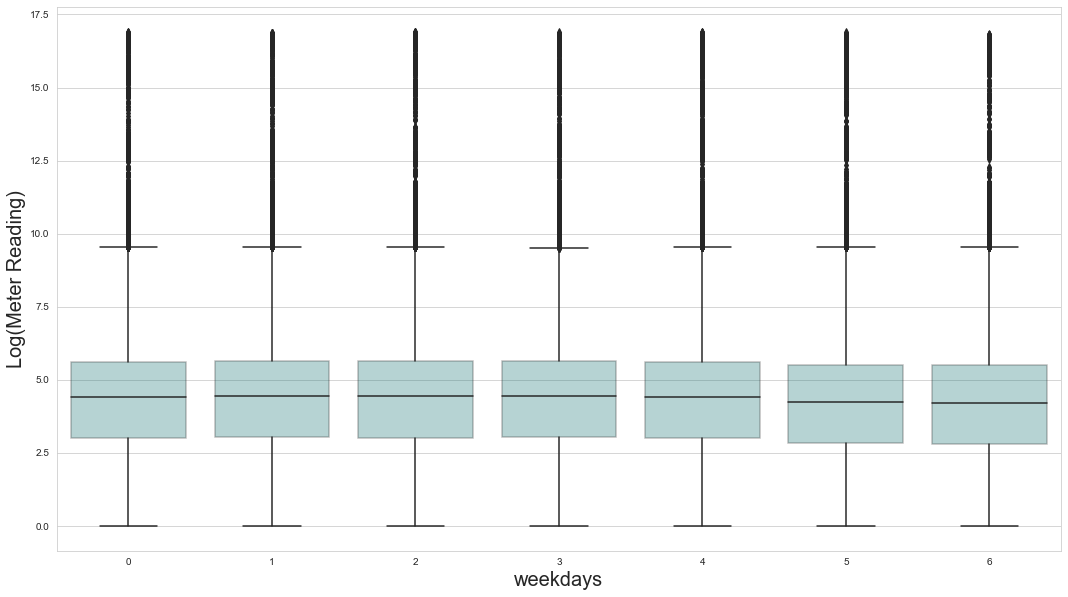

In [27]:
bold('**SUNDAYS HAVE THE LOWEST READINGS**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.boxplot(data = train, x ='weekday', y = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_ylabel('Log(Meter Reading)', fontsize = 20)
ax.set_xlabel('weekdays', fontsize = 20)
plt.show()

## 3.4 Time of Day and Meter Reading

**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**

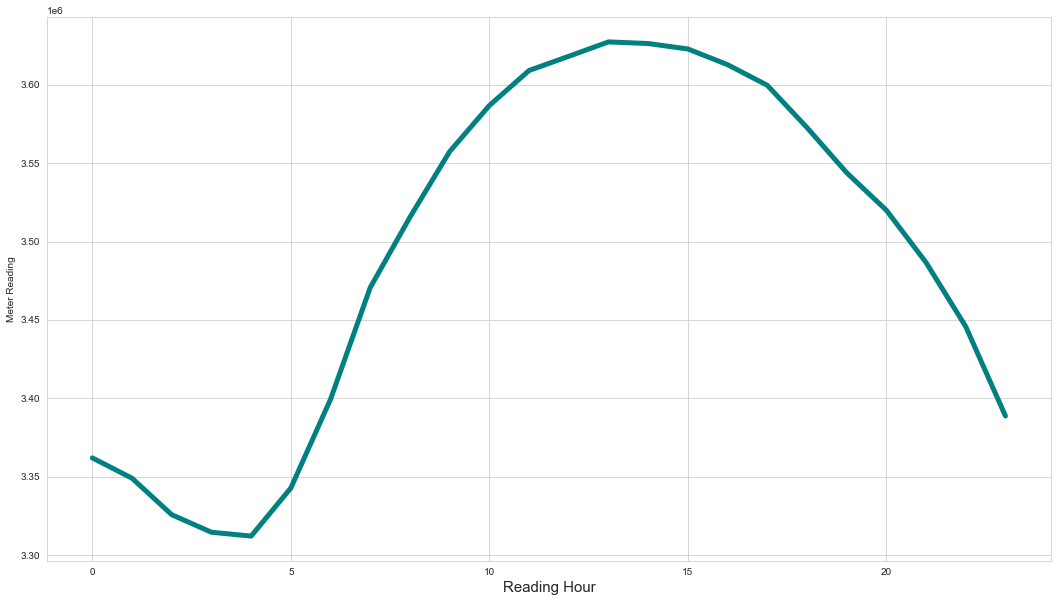

In [28]:
bold('**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**')
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby('hour').meter_reading.sum()
temp_df.plot(linewidth = 5, color = 'teal')
plt.xlabel('Reading Hour', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

Reading are significantly higher during traditional work hours and this is to be expected. Time of day appears like it will be a significant predictor in any subsequent model for this competition.

# 3.5 Primary Use and Meter Reading

**MONTHLY READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE**

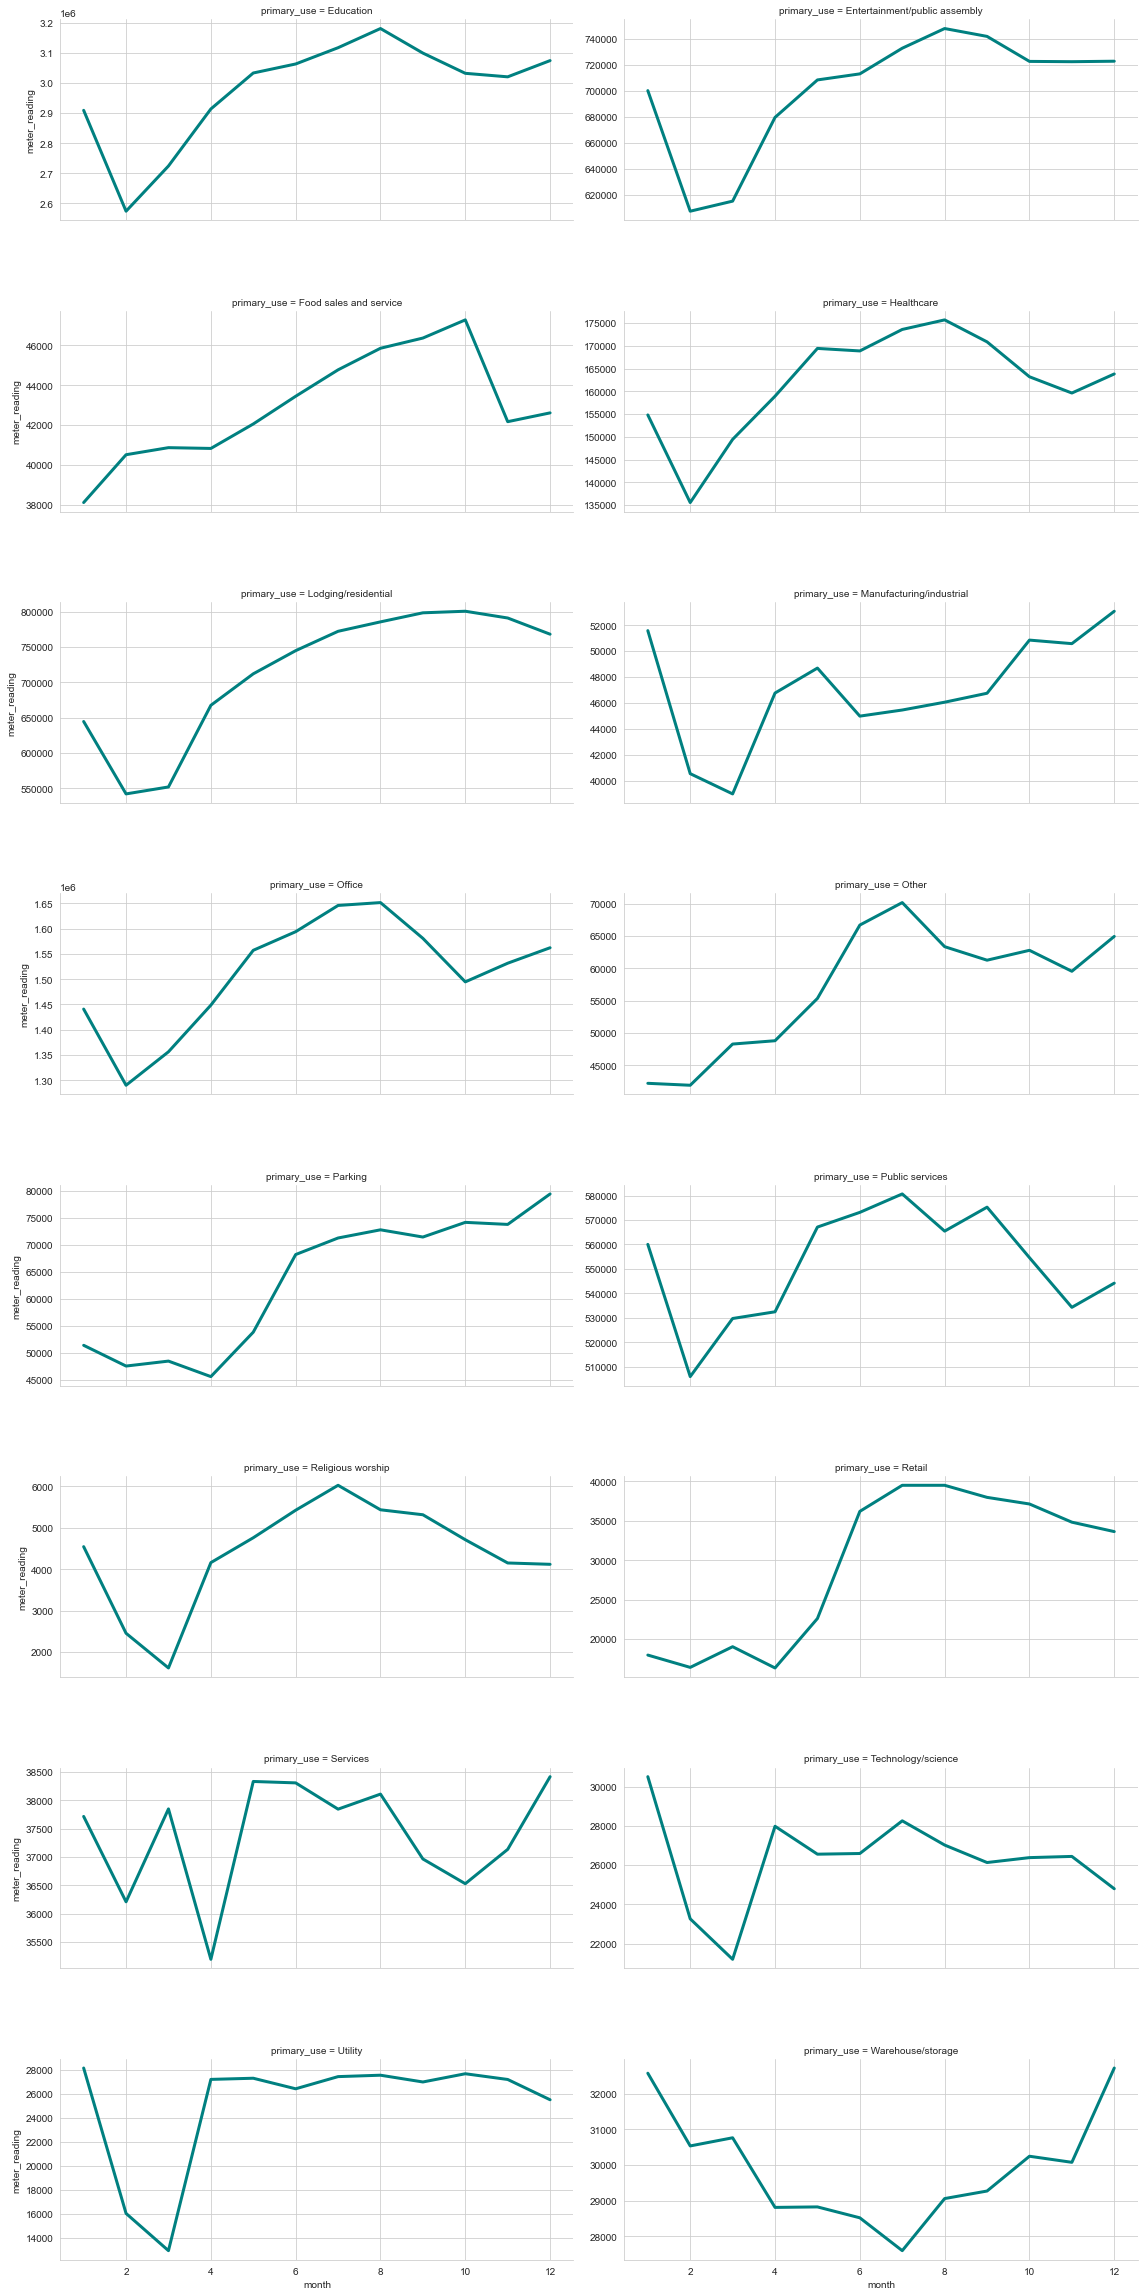

In [29]:
bold('**MONTHLY READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE**')
temp_df = train.groupby(['month', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

There are considerable differences between building types as to when meter readings are highest. Almost all the building peak in the end of the year due to winter season.

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**

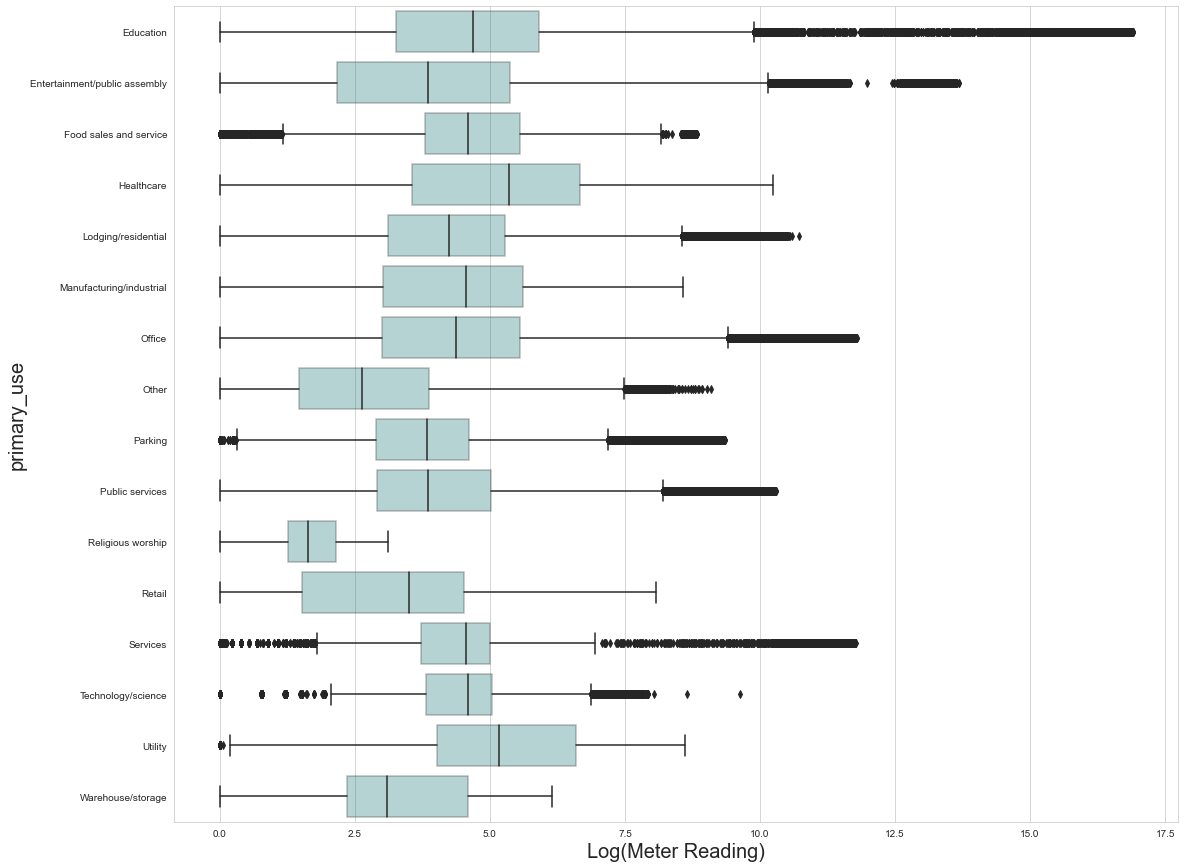

In [30]:
bold('**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**')
plt.rcParams['figure.figsize'] = (18, 15)
ax = sns.boxplot(data = train, y ='primary_use', x = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

We can see that Utility and Healthcare places tend to have the highest readings, while Religious Worship places the least - they’re no doubt frequented less often than the higher energy users.

**PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS**

/Users/anaflaviagama/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



KeyboardInterrupt: 

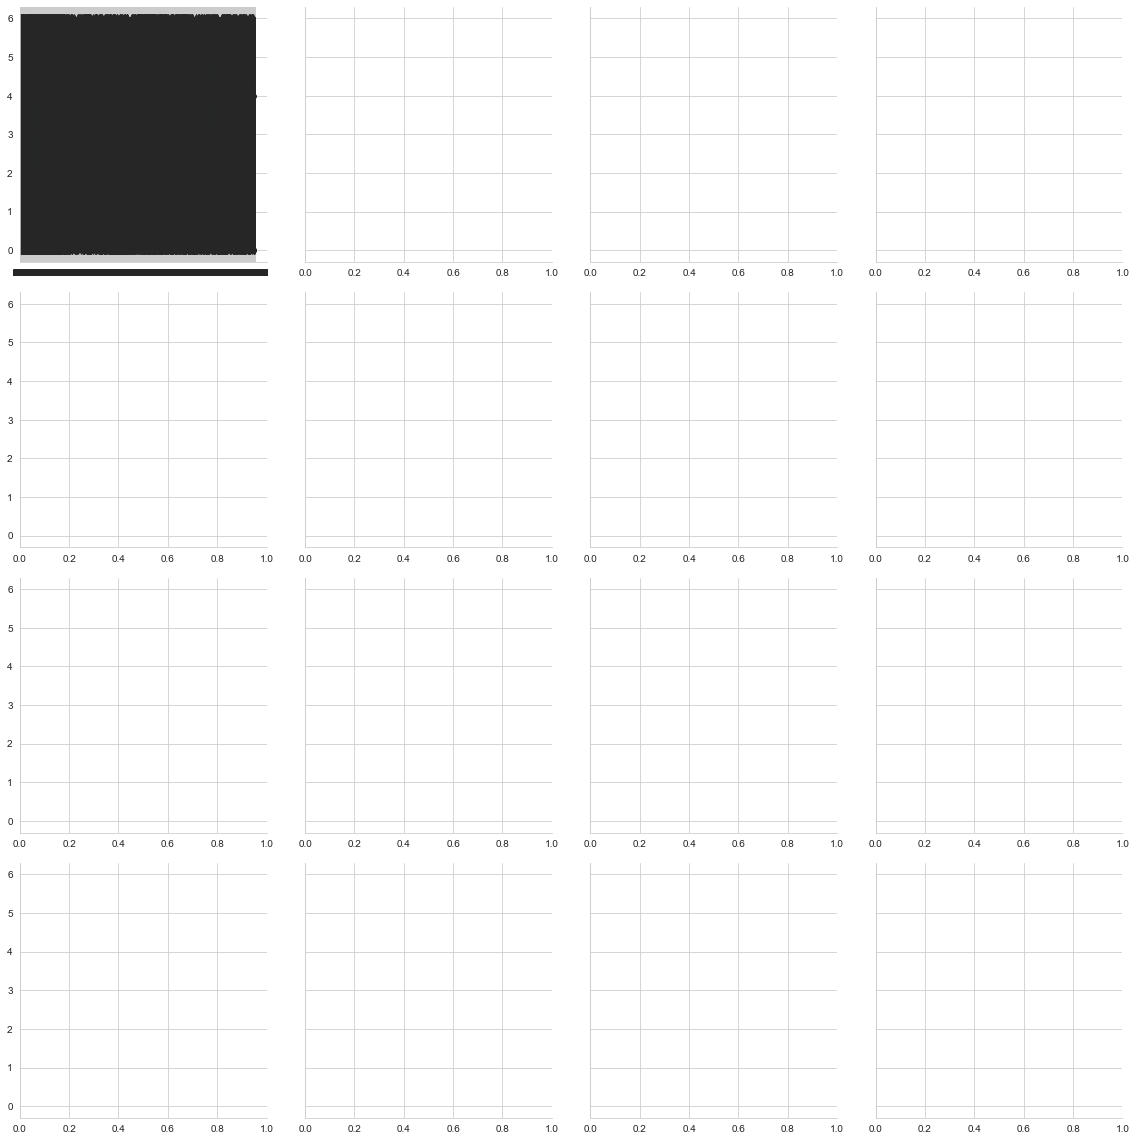

In [31]:
bold('**PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS**')
ax = sns.FacetGrid(train, col="primary_use", col_wrap=4, height=4, aspect=1,  sharex=False)
ax.map(sns.boxplot, 'meter_reading', 'weekday', color="teal",   boxprops=dict(alpha=.3))
plt.subplots_adjust(hspace=0.45)
plt.show()

Healthcare, Education, Manufacturing/ Industrial, Techonology/science, Utilities building has highest reading on weekdays compares to the others.

Religious worship places have higher readings on weekends.



## 3.6 Meter Readings over time

In [ ]:
bold('**READINGS REALLY PEAKED FROM MAY TO OCTOBER**')
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby(['timestamp', 'month']).meter_reading.sum().reset_index()
ax = sns.lineplot(data = temp_df, x = 'timestamp', y = 'meter_reading', color = 'teal')
plt.xlabel('Timestamp', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

Interestingly, the meter reading per reading began rising in May and peaked between July and October 2016.

### Meter Readings over time And Primary Use

In [ ]:
bold('**MANUFACTURING REALLY BUCKED THE GENERAL TREND**')
temp_df = train.groupby(['timestamp', "primary_use"]).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(sns.lineplot,'timestamp',  'meter_reading', color="teal")
plt.subplots_adjust(hspace=0.45)
plt.show()

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

## 3.7 Correlation between meter_reading And Numeric Variable

In [ ]:
plt.rcParams['figure.figsize'] = (18,10)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

Square feet and floor count highly positive correlated ie, the bigger the building, the higher the reading and year building build and meter type moderate positive correlated also.

wind_speed, air_temperature and cloud_coverage may be important in any model that gets built.

## 3.8 Square Feet

In [ ]:
'''Distribution of the Meter Reading'''
distplot(train['square_feet'], 'darkgreen')

Square feet size is positively Skewed.

In [ ]:
'''Log tranformation of meter_reading'''
train['square_feet'] = np.log1p(train['square_feet'])
test['square_feet'] = np.log1p(test['square_feet'])

bold('**Distribution after log tranformation**')
distplot(train['square_feet'], 'darkgreen')

## 3.9 Year Built

In [ ]:
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby('year_built').building_id.sum().reset_index()
ax = sns.lineplot(data = temp_df, x = 'year_built', y = 'building_id', color = 'black', linewidth = 3.5)
plt.xlabel('Year Built', fontsize = 15)
plt.ylabel('Building_ID', fontsize = 15)
plt.show()

## 3.10 Floor Count

In [ ]:
'''Distribution of the Meter Reading'''
distplot(train['floor_count'].dropna(), 'darkred')

There are 16,709,167 missing records in the floor_count variable. Of the 1449 unique building IDs, 1094 don’t have a floor count.

Of those that do, we can see that there aren’t too many buildings with more than 10 floors, while the median number of floors is 3.

## 3.11 Air Temperature

In [ ]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['air_temperature'].dropna(), shade = True, color = 'gold')
plt.xlabel('Air Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~10 and 25 degrees.

## 3.12 Dew Temperature

In [ ]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['dew_temperature'].dropna(), shade = True, color = 'indigo')
plt.xlabel('Dew Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~13 and 25 degrees.

## 3.13 Wind Speed

In [ ]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['wind_speed'].dropna(), shade = True, color = 'peru')
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between 1.5 and 3.5 Meters per second

## 3.14 Wind direction & Wind speed
In heatmap plot wind direction and wind speed are highly correlated. So, it is good to plot together.

wind_direction - Compass direction (0-360)

wind_speed - Meters per second

Ok, plotting this is tricky, so I am going to do it using [this manual](https://gist.github.com/phobson/41b41bdd157a2bcf6e14)

Code source: https://www.kaggle.com/nroman/eda-for-ashrae

First of all: direction of 0° and 360° is the same thing. But both are presented in the datasets.

In [ ]:
def speed_labels(bins:list, units:str) -> list:   
    labels = list()
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return labels

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, np.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

In [ ]:
calm_count = train[train['wind_speed'] == 0].shape[0]
total_count = len(train)
rose = (train.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)
directions = np.arange(0, 360, 15)

In [ ]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)
            # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig


This is a wind rose for TRAIN:

In [ ]:
fig = wind_rose(rose, directions)

# 4. Feature Engineering - Part II

## 4.1 Imputing Missing variable

In [ ]:
'''Imputing missing value of year build'''
train['year_built'] = np.uint8(train['year_built']-1900, inplace = True)
test['year_built'] = np.uint8(test['year_built']-1900, inplace = True)

In [ ]:
'''The following variables are either discrete numerical or continuous numerical variables.So the will be imputed by median'''
to_impute_by_median = train.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    train[i].fillna(train[i].median(), inplace = True)

to_impute_by_median = test.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    test[i].fillna(test[i].median(), inplace = True)

## 4.2 Encoding Categorical Variable

In [ ]:
'''Using sklearn's label encoder method'''
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])
test['primary_use'] = le.fit_transform(test['primary_use'])

In [ ]:
'''Now extract the nominal variables for one hot encoding of train and test data.'''
one_hot_train = pd.get_dummies(train['meter'])

one_hot_test = pd.get_dummies(test['meter'])

In [ ]:
'''Droping variable'''
train.drop(columns=['meter', 'timestamp', 'weekday_name'], axis = 1, inplace = True)
test.drop(columns=['meter', 'timestamp'], axis = 1, inplace = True)

In [ ]:
"""Let's concate one hot encoded, other variables together."""
train_processed = pd.concat([one_hot_train, train], axis = 1)
test_processed = pd.concat([one_hot_test, test], axis = 1)

# Baseline

In [ ]:
"""Let's look at our final train and test data for modelling."""
bold('**Updated train data for modelling:**')
display(train_processed.head(3))
bold('**Updated test data for modelling:**')
display(test_processed.head(3))

In [ ]:
'''Setting train, test and target for model'''
target = train_processed['meter_reading']
train = train_processed.drop(['meter_reading'], axis = 1)
test = test_processed.drop(['row_id'], axis = 1)

In [ ]:
"""Let's have a final look at our data"""
bold('**Data Dimension for Model Building:**')
print('Input matrix dimension:', train.shape)
print('Output vector dimension:',target.shape)
print('Test data dimension:', test.shape)

In [ ]:
cat_feat = ['ChilledWater', 'Electricity', 'HotWater', 'Steam',"site_id", "building_id", "primary_use", "hour", "weekday", "wind_direction"]

# Modeling simple LGBM

In [ ]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 4
seed = 55
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
# oof_pred = np.zeros(train.shape[0])  # out of fold predictions
models = []

## stratify data by building_id
for train_index, val_index in tqdm(kf.split(train, train['building_id']), total=folds):
    train_X = train.iloc[train_index]
    val_X = train.iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=cat_feat)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=cat_feat)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)

In [ ]:
plt.rcParams['figure.figsize'] = (18,10)
lgb.plot_importance(models[0], importance_type='gain')
plt.show()

# Prediction and Submission

In [ ]:
i=0
result=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    result.append(np.expm1(sum([model.predict(test.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

In [ ]:
'''Submission'''
result = np.concatenate(result)
submission = pd.read_csv("../input/ashrae-energy-prediction/sample_submission.csv")
submission["meter_reading"] = result
submission.to_csv("submission.csv", index = False)

# <font color='teal'>Give me your feedback and if you find my kernel helpful please UPVOTE will be appreciated.</font> 